In [1]:
### Alex Fang
### CMSC320 - Fall 17
### Final Tutorial

In [2]:
### UFO Sightings in the 21st century US
# UFOs, mysterious alien ships come to vist earth. They can cause controversy and fear, but also 
# inspire amazement and wonder. How many people have seen one, or at least claim to have seen one? 
# In this tutorial, we will examine the reported UFO sightings in the 21st century for the United 
# States. After collecting the data from Kaggle, we will parse and format it for analysis, then look
# at statistics for the time of sightings as well as the location. Finally we will take a look at how
# to use this information to predict metrics for future UFO sightings using linear regression.

In [ ]:
## Tools Used
# I will be using the following tools and applications in this tutorial:
# Python 3 - https://www.python.org/download/releases/3.0/
# Jupyter Notebooks - http://jupyter.org/index.html
# Pandas - https://pandas.pydata.org/pandas-docs/stable/
# Numpy - https://docs.scipy.org/doc/numpy-dev/user/quickstart.html
# Scikit-learn - http://scikit-learn.org/stable/
# Matplotlib - https://matplotlib.org/
# Folium - https://folium.readthedocs.io/en/latest/
# Kaggle - https://www.kaggle.com/NUFORC/ufo-sightings

In [267]:
## Imports
# You'll need to make sure that you successfully import and install all the libraries used 
# in this toutorial, otherwise there will be errors when you try and run the program. 

# Make sure folium is properly set up
!pip install folium

# Import needed libraries
import folium
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re

# Add in specific libraries
from folium.map import *
from sklearn import linear_model
from statsmodels.formula.api import ols

In [275]:
## Data Collection
# We will be using a dataset from Kaggle, so the first step is to download the .csv file from 
# https://www.kaggle.com/NUFORC/ufo-sightings. Then, after extracting the scrubbed data file 
# and placing it in the same folder as the code you'll be running, we need to load the data into 
# a pandas data frame. 
df = pd.read_csv("scrubbed.csv", dtype=object)

# Check to see the data was imported successfully
df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.9411111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.6458333
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.8036111


In [276]:
# First we can seperate out the datetime into year/month/hour as we will be using these time 
# metrics for our analysis later. It is also important that we cast these columns to an integer
# type so that we can order them appropriately. The following code will extract each needed
# metric and create it's own column. 
df['year'] = df['datetime'].str.split(' ').str.get(0).str.split('/').str.get(2).astype(int)
df['month'] = df['datetime'].str.split(' ').str.get(0).str.split('/').str.get(0).astype(int)
df['hour'] = df['datetime'].str.split(' ').str.get(1).str.split(':').str.get(0).astype(int)
df = df.drop('datetime', 1)

# Sometimes midnight will be listed as hour 24 and sometimes as hour 0. We will standardize this to 0.
df.loc[df['hour'] > 23, 'hour'] = 0

# We will also want to change the latitude, longitude, and duration values from strings to floats, 
# as well as remove any input errors in the data (such as the 'q' hidden in a latitude value).
df['latitude'] = df['latitude'].str.replace('q','')
df['latitude'] = df['latitude'].astype(float, errors='ignore')
df['longitude '] = df['longitude '].astype(float, errors='ignore')
df['duration (seconds)'] = df['duration (seconds)'].str.replace('`','')
df['duration (seconds)'] = df['duration (seconds)'].astype(float)

# Then we will remove all rows that corrispond to a sighting outside the US, and all rows from before 
# the 21st century. 
df = df[df['year'] > 1999]
df = df[df['country'] == 'us']

# We will also remove rows from after 2013, as our data collection ends in mid 2014. 
df = df[df['year'] < 2014]

# Now we can tidy the data by first removing some of the columns that will not be important for 
# this tutorial.
df = df.drop('city', 1)
df = df.drop('country', 1)
df = df.drop('duration (hours/min)', 1)
df = df.drop('shape', 1)
df = df.drop('date posted', 1)

# We will also want to remove any duplicate entries so that they are not counted twice in our 
# analysis. 
df = df.drop_duplicates()

# We can now check to see our successfully tidied dataframe
df.head()
df.tail()

,state,duration (seconds),comments,latitude,longitude,year,month,hour
80327,tn,600.0,Round from the distance/slowly changing colors...,36.165833,-86.784444,2013,9,21
80328,id,1200.0,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,43.613611,-116.202500,2013,9,22
80329,ca,1200.0,Napa UFO&#44,38.297222,-122.284444,2013,9,22
80330,va,5.0,Saw a five gold lit cicular craft moving fastl...,38.901111,-77.265556,2013,9,22
80331,ok,1020.0,2 witnesses 2 miles apart&#44 Red &amp; White...,35.652778,-97.477778,2013,9,23


In [279]:
## Time Analysis
# One easy measurement to start with is the duration of each sighting. We can look at an average of 
# the sighting duration in seconds, to get an idea of how long UFO sightings usually last. 
print('The average UFO sighting duration in minutes is: ' + str(df['duration (seconds)'].mean()/60))

The average UFO sighting duration in minutes is: 71.9723537954


In [ ]:
# It's really interesting that most people who see UFO's these days report seeing them for over an
# hour. I would have originally expected this value to be much lower. 

In [253]:
# The second measurement we will look at will be how many ufo sightings were there each year between 
# 2000 and 2013. To do this we will create a copy of the datetime column, and count the number of
# rows for every given year. The groupby function of pandas is useful here to create a data table
# with unique year values and a count of the number of rows containing that year. 
sightings_by_year = df.copy().groupby(df['year'], as_index=True, group_keys=True).count()
sightings_by_year = sightings_by_year[['month']].reset_index()
sightings_by_year = sightings_by_year.rename(index=str, columns={'month':'count'})

# We can check our table to see that the years and counts are being stored successfully. 
sightings_by_year.head()

,year,count
0,2000,2184
1,2001,2444
2,2002,2439
3,2003,2958
4,2004,3243


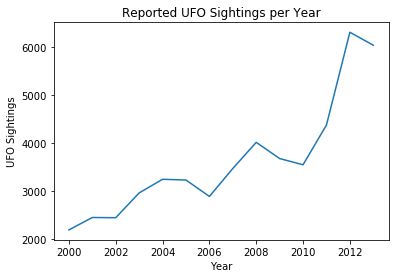

In [254]:
# We will now visualize this data by creating a line plot to graph the number of reported UFO
# sightings per year. This is a relatively simple process and can be done in just a few lines.  
plt.plot(sightings_by_year['year'], sightings_by_year['count'])
plt.title('Reported UFO Sightings per Year')
plt.ylabel('UFO Sightings')
plt.xlabel('Year')
plt.show()

In [255]:
# Wow, the trend for number of UFO sightings in the 21st century is clearly a steep increase, 
# growing almost 200% in the 13 years. There are only a few years, 2006, 2009, and 2010 where we 
# see the number of sightings decrease from the previous year. The highest point in our graph is 
# 2012, where there were over 6000 remorted sightings. 

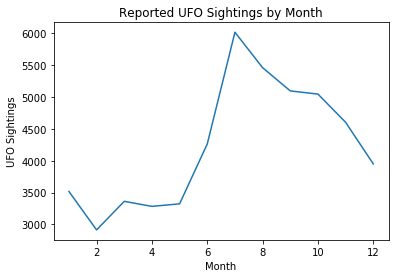

In [256]:
# Lets now create a similar visualization for months, and see what time of year people are most 
# likely to see UFOs.
sightings_by_month = df.copy().groupby(df['month'], as_index=True, group_keys=True).count()
sightings_by_month = sightings_by_month[['year']].reset_index()
sightings_by_month = sightings_by_month.rename(index=str, columns={'year':'count'})

# Before we plot this one, we'll have to sort the data frame by month, as we are no longer 
# looking as the data in chronological order. 
sightings_by_month['month'] = sightings_by_month['month'].astype(int)
sightings_by_month = sightings_by_month.sort_values(['month'])

# Now that we have our data sorted, lets make another graph. 
plt.plot(sightings_by_month['month'], sightings_by_month['count'])
plt.title('Reported UFO Sightings by Month')
plt.ylabel('UFO Sightings')
plt.xlabel('Month')
plt.show()

In [257]:
# Clearly UFO sightings occurr most often in the summer and fall, especially in July and August. 
# This may be because more people are outside in the warm weather, looking up into the sky. On the 
# opposite end of the spectrum, February is the month with by far the least number of sightings, 
# about hald of the number in July. However, this number may be skewed due to February having
# less days than the other months, meaning less time spent looking for UFOs.

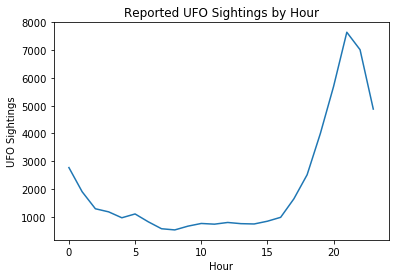

In [258]:
# Finally, lets create one more graph for time of day, and see what hour people most often see UFOs.
# Now that we've gone through the steps a few times, we can put this one together all at once!
sightings_by_hour = df.copy().groupby(df['hour'], as_index=True, group_keys=True).count()
sightings_by_hour = sightings_by_hour[['year']].reset_index()
sightings_by_hour = sightings_by_hour.rename(index=str, columns={'year':'count'})
sightings_by_hour['hour'] = sightings_by_hour['hour'].astype(int)
sightings_by_hour = sightings_by_hour.sort_values(['hour'])
plt.plot(sightings_by_hour['hour'], sightings_by_hour['count'])
plt.title('Reported UFO Sightings by Hour')
plt.ylabel('UFO Sightings')
plt.xlabel('Hour')
plt.show()

In [259]:
# Wow! 9 and 10pm clearly hold the majority of UFO sightings, with the reports quickly lessening 
# from 11 to 12, and picking up again around 8pm the next day. This kind of result should be expected,
# as most people are still awake at 9pm, and the sky is almost always dark enough to make out lights 
# in the sky.

In [260]:
## Location Analysis
# We will now create a similar count table, but this time look at which states had the most UFO 
# sightings. Again, we can use pandas groupby to help us count the number of sightings in each state.
sightings_by_state = df.copy().groupby(df['state'], as_index=True, group_keys=True).count()
sightings_by_state = sightings_by_state[['year']].reset_index()
sightings_by_state = sightings_by_state.rename(index=str, columns={'year':'count'})
sightings_by_state = sightings_by_state.sort_values(['state'], ascending=False)

# Lets check to make sure the table looks like what we expect it to. 
sightings_by_state.head()

,state,count
51,wy,132
50,wv,334
49,wi,954
48,wa,3010
47,vt,227


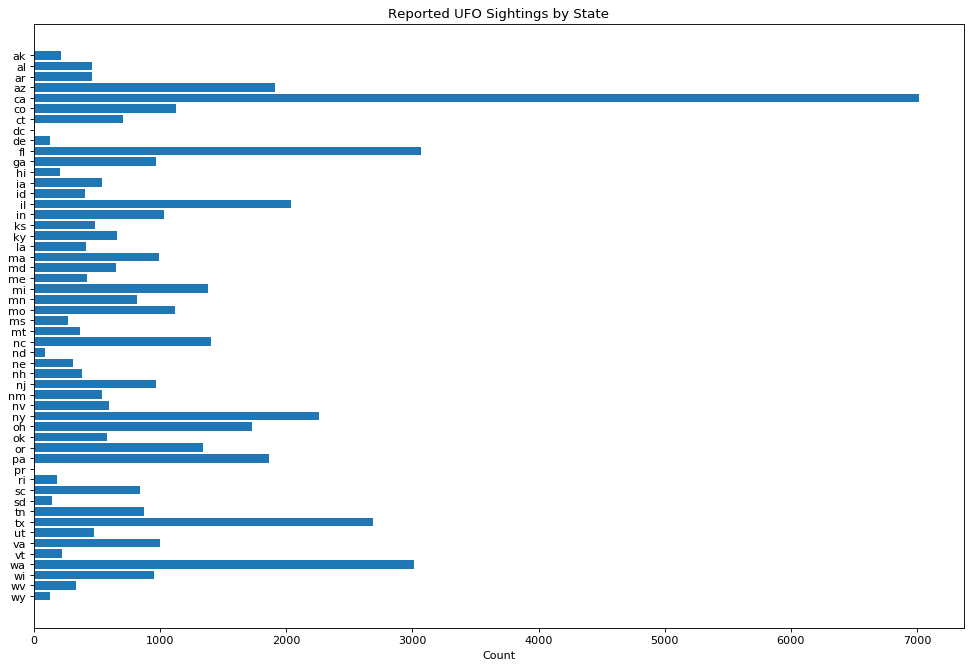

In [261]:
# Our table is working, so lets create a new type of graph to visualize the results.
# First initilize the graph using matplotlib
%matplotlib inline
plt.figure(figsize=(15, 10), dpi=80);

# Now we will create lables for our states and add them to the left of our graph with the count of
# each state moving along to the right.
states = np.arange(len(sightings_by_state['state']))
plt.barh(states, sightings_by_state['count'])

# Finally we can add in our lables and show off our plot. 
plt.yticks(states, sightings_by_state['state'])
plt.xlabel('Count')
plt.title('Reported UFO Sightings by State')

In [262]:
# We can clearly see that California leads the country in UFO sightings, with almost 7000 between the 
# years 2000 and 2013. This can be partially attributed to the the large population size in 
# California, which currently makes up over 12% of all the people living in the united states. 
# Still, the state with the second highest population and over 8% of the country, Texas, is only 4th
# on our list of UFO sightings. Although this chart gives us a good idea of the states with the
# highest sighting counts, its not great at showing us exactly where these sightings ocurr. For that
# we will move on to our next task.

In [263]:
# Our first graph was interesting, but this one will be even better. We will now attempt to take a 
# sample of the UFO sightings and add them to an interactive map, where you'll be able to explore
# where, when, and what people have seen up in the night sky. We will use folium to map these results
# and visualize the actual locations and densities of these sightings. 

# First we will create our map object and center it around the contiguous United States.
map_osm = folium.Map(location=[37.3, -98], zoom_start=3.5)

# Because this takes a while to run, we will take a sample of 500 random sightings to plot on our 
# map. This will give us a good idea of the overall disribution of sightings across the United States.
# We'll store these samples in a feature group called sightings. For more on how this works, please 
# take a look at the documentation over on https://folium.readthedocs.io/en/latest/
sightings = FeatureGroup(name='sightings')
for i in random.sample(range(0, len(df['state'])), 500):
    loc=[df['latitude'].values[i], df['longitude '].values[i]]
    sightings.add_child(folium.Circle( 
        color='red', 
        # Adding a popup here will allow you to click on a point and see the year and discription
        # of the sighting
        popup="Year:" + str(df['year'].values[i]) + ". Discription:" + str(df['comments'].values[i]),
        fill=True,
        location=loc,
        radius=100, 
    ))
    
# Now that our samples sightings have been added to our feature group, its time to add them into the 
# map and show them off.
map_osm.add_child(sightings)
map_osm

In [264]:
# There's a lot going on in this map, but lets try and break it down. First and foremost, we can see
# that there appear to be more sightings spread out on the eastern side of the US than the west, 
# especially the mid to northwest. However, we see strong clustering on the west coast over major 
# cities such as Los Angeles, San Fransisco, Portland, Seattle, and Phoenix. The eastern side of the
# states have some of this city influenced clustering as well, with concentrations in New York,
# Boston, and Chicago. Nevertheless, in general we see a much wider distribution of the sightings.
# In general, the grouping we see over the cities makes sense, as the higher population density in 
# places like Los Angeles and New York allow for many more people to be looking up at the sky in that
# area. The distribution on the east side also makes sense in regard to population, as the east
# side of the United States has an overall higher population than the western side. 

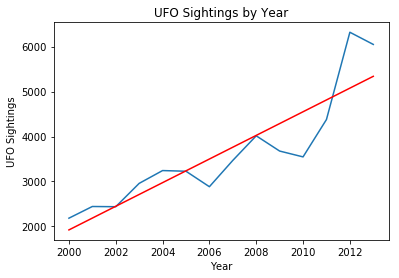

In [266]:
## Models and Regression
# Lets begin by creating a simple linear regression for number of UFO sightings per year and see how
# accurately we can fit the data using only this one variable.

# First we'll create a linear regression object, and fit the year and count values from the first 
# table we made to the model.
reg = linear_model.LinearRegression()
X = [[year] for year in sightings_by_year['year'].values]
y = [[count] for count in sightings_by_year['count'].values]
reg_model = reg.fit(X, y)

# Now that we've created the model, we can create a series of predictions for 2000-2013, and add
# those predictions into our table along side the real numbers.
pred_counts = []
for i in sightings_by_year['year'].values:
    pred_counts.append(reg_model.predict(i)[0][0])
sightings_by_year['pred_count'] = pd.Series(pred_counts, index=sightings_by_year.index)

# Now that both the real data and the predicted model is in the same table, it is a simple step to 
# add them both to a line plot and visualize how the model fits the data. 
plt.plot(sightings_by_year['year'], sightings_by_year['count'])
plt.plot(sightings_by_year['year'], sightings_by_year['pred_count'], color='red')
plt.xlabel("Year")
plt.ylabel("UFO Sightings")
plt.title("UFO Sightings by Year")

In [281]:
# We can see that our linear model closely follows the upward trend of UFO sightings in the 21st 
# century. In the year 2002, 2005, and 2008, the model predicts the data so closely that it looks like
# the same point on the graph. Using this model, we can extrapolate out to the future and attempt
# to make a statement about this year. For instance, if we had to guess how many UFOs were sighted
# this year in 2017, we can simply plug that year into our model.
print("The number of UFO sightings in 2017 is probably around: " +
      str(int(reg_model.predict(2017)[0][0])))

The number of UFO sightings in 2017 is probably around: 6389


In [290]:
# Now that is pretty cool, but we can do even more. Say we wanted to predict the number of sightings
# here in Maryland. Our current model has no way of splitting up its predictions by state, so we'll 
# need to create something else. 

# Lets begin by creating a new table, that tracks the number of sightings by both year and state.
# Again, we'll be using groupby to get the count of each unique year/state combination
sightings_year_state = df[['year', 'state']].copy()
sightings_year_state = sightings_year_state.groupby(['year', 'state']).size().reset_index()
sightings_year_state = sightings_year_state.rename(index=str, columns={0:'count'})

# Now lets see what our table looks like
sightings_year_state.head()

,year,state,count
0,2000,ak,11
1,2000,al,18
2,2000,ar,31
3,2000,az,174
4,2000,ca,380


In [291]:
# Awesome, we now have a table that counts sightings by year and state, so we are ready to begin with 
# our model. 

# This time we'll use OLS regression, as the library makes it a bit easier for us when we model 
# multiple variables. For more information on how this OLS regression works, check out 
# http://www.statsmodels.org/stable/index.html
ols_model = ols(formula='count ~ (year * state) + year + state', data=sightings_year_state).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     100.9
Date:                Thu, 14 Dec 2017   Prob (F-statistic):          1.63e-320
Time:                        13:42:13   Log-Likelihood:                -3139.6
No. Observations:                 707   AIC:                             6487.
Df Residuals:                     603   BIC:                             6962.
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3503.5209   2957.022     -1.185      0.237   -9310.834    2303.792
state[T.al]      -1918.7275   4181.861     -0.459      0.647   -1.01e+04    6294.053
state[T.ar]       1260.8747   4181.861      0.302      0.763   -6951.906    9473.655
state[T.az]      -2335.2374   4181.861     -0.558      0.577   -1.05e+04    5877.543
state[T.ca]      -3.627e+04   4181.861     -8.673      0.000   -4.45e+04   -2.81e+04
state[T.co]      -3101.4440   4181.861     -0.742      0.459   -1.13e+04    5111.337
state[T.ct]      -1.078e+04   4181.861     -2.577      0.010    -1.9e+04   -2565.413
state[T.dc]        489.3542   3.17e+04      0.015      0.988   -6.19e+04    6.28e+04
state[T.de]       1682.7736   4181.861      0.402      0.688   -6530.007    9895.554
state[T.fl]      -3.783e+04   4181.861     -9.046      0.000    -4.6e+04   -2.96e+04
state[T.ga]      -8201.6000   4181.861     -1.961      0.050   -1.64e+04      11.181
state[T.hi]        290.0527   4181.861      0.069      0.945   -7922.728    8502.833
state[T.ia]      -2732.9670   4181.861     -0.654      0.514   -1.09e+04    5479.813
state[T.id]      -2777.9604   4181.861     -0.664      0.507    -1.1e+04    5434.820
state[T.il]      -1.401e+04   4181.861     -3.350      0.001   -2.22e+04   -5795.184
state[T.in]      -7795.9429   4181.861     -1.864      0.063    -1.6e+04     416.838
state[T.ks]       -311.8132   4181.861     -0.075      0.941   -8524.594    7900.967
state[T.ky]      -3734.4747   4181.861     -0.893      0.372   -1.19e+04    4478.306
state[T.la]       -224.1341   4181.861     -0.054      0.957   -8436.915    7988.646
state[T.ma]      -1.168e+04   4181.861     -2.794      0.005   -1.99e+04   -3470.776
state[T.md]      -5450.2791   4181.861     -1.303      0.193   -1.37e+04    2762.501
state[T.me]      -3429.3385   4181.861     -0.820      0.413   -1.16e+04    4783.442
state[T.mi]      -1.264e+04   4181.861     -3.022      0.003   -2.09e+04   -4426.538
state[T.mn]      -7489.3780   4181.861     -1.791      0.074   -1.57e+04     723.402
state[T.mo]      -8239.6088   4181.861     -1.970      0.049   -1.65e+04     -26.828
state[T.ms]        841.4505   4181.861      0.201      0.841   -7371.330    9054.231
state[T.mt]      -2106.3187   4181.861     -0.504      0.615   -1.03e+04    6106.462
state[T.nc]      -1.984e+04   4181.861     -4.745      0.000   -2.81e+04   -1.16e+04
state[T.nd]       3068.9604   4181.861      0.734      0.463   -5143.820    1.13e+04
state[T.ne]        804.8330   4181.861      0.192      0.847   -7407.948    9017.613
state[T.nh]      -2717.9363   4181.861     -0.650      0.516   -1.09e+04    5494.844
state[T.nj]      -7169.8286   4181.861     -1.715      0.087   -1.54e+04    1042.952
state[T.nm]      -1405.9473   4181.861     -0.336      0.737   -9618.728    6806.833
state[T.nv]        785.

In [305]:
# Now I know that's a lot of data that just printed out, but there's no need to worry. It's a model
# just like the simple one that we started with, only this time we can account for seperate states
# as well. Most of the numbers you see are coefficients for a state, a year, or a combination of both
# that the model will use when is it making it's calculations.

# Now back to our prediction. We wanted to know how many UFO sightings will happen in Maryland in the 
# year 2017. By creating a dataframe with one entry, the year being 2017 and the state being
# Maryland, we can pass this new dataframe into our model and see the prediction.
print("The number of UFO sightings in Maryland in 2017 is probably around: " +
    str(int(ols_model.predict(pd.DataFrame({'year':2017, 'state':'md'}, index=[0]))[0])))

The number of UFO sightings in Maryland in 2017 is probably around: 93


In [ ]:
# Thats great! We've taken data from all over the US in the 21st century, and used it to predict 
# something that very well may be going on as you read this. How cool is that!

In [ ]:
## Conclusion
# Until we travel out into the stars, UFOs will always captivate those who want to believe in 
# something out there with us. The idea that another lifeform is close enough to see with our naked
# eye is almost as cool as using data science to predict the number of crafts that we think we'll see.
# Based on our dataset, we can clearly see that there is a steady increase in the number of UFO 
# sightings accross the United States, wherever and whenever people are looking for them. It doesn't
# take a lot to look up in the sky, and our predictions estimate that almost 100 people in our own
# state have looked up and seen something amazing and unexplainable this year. 